# Vizdoom2

https://youtu.be/eBCU-tqLGfQ



In [1]:
from vizdoom import *

import random
import time

import numpy as np

In [6]:
game = DoomGame()
game.load_config('github/VizDoom/scenarios/defend_the_center.cfg')
game.init()

In [7]:
game.new_episode()

# This is the set of actions we can take in the environment.
actions = np.identity(3, dtype=np.uint8)

episodes = 1
for episode in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        # get the state
        state = game.get_state()
        
        # get the screen buffer
        img = state.screen_buffer
        
        
        info = state.game_variables
        
        # choose action
        action = random.choice(actions)
        
        # take action and get reward
        reward = game.make_action(action, 4)
        
        # print reward
        print('reward: ', reward)
        time.sleep(0.02)
    time.sleep(2)

reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  0.0
reward:  -1.0


In [4]:
game.get_state()

In [8]:
game.new_episode()
print(game.get_state().screen_buffer.shape)
game.close()

(3, 240, 320)


## 2. Converting it in a Gym environment

In [10]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [12]:
class VizDoomGym(Env):
    """VizDoom OpenAI Gym environment"""
    
    def __init__(self, render=False):
        """Initialize the environment"""
        
        # inherit from the base class
        super().__init__()
        
        # Setup the game
        self.game = DoomGame()
        self.game.load_config('github/VizDoom/scenarios/defend_the_center.cfg')
        
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        # create the action space and observation space
        self.observation_space = Box(
            low=0, 
            high=255, 
            shape=(100, 160, 1), 
            dtype=np.uint8
            )
        self.action_space = Discrete(3)
        
        
    def step(self, action):
        """Take a step in the environment"""
        
        actions = np.identity(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action], 4)
        
        if self.game.get_state():
            # if we get a state
            
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state) # transform the image to grayscale
            info = self.game.get_state().game_variables
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0

        info = {"info": info}
        done = self.game.is_episode_finished()

        return state, reward, done, info # our state is the image
        
    def close(self):
        """close the environment"""
        
        self.game.close()
        
    def render():
        """Render the environment"""
        pass
    def grayscale(self, observation):
        """Transform the image to grayscale"""
        
        gray = cv2.cvtColor(
            np.moveaxis(observation, 0, -1), # reorders observation shape from (3, 240, 320) to (240, 320, 3)
            cv2.COLOR_RGB2GRAY
            )
        
        # make image smaller
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        
        return state
    
    def reset(self):
        """Reset the environment"""
        
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    

In [13]:
env=VizDoomGym()

In [14]:
state = env.reset()

In [15]:
state.shape

(100, 160, 1)

### 2.1 Environment checker

In [16]:
from stable_baselines3.common import env_checker

In [17]:
env_checker.check_env(env)

## 3. View Environment

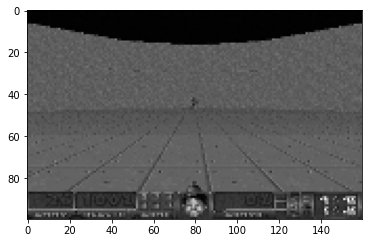

In [18]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [19]:
env.close()

## 4. Setup Callback

In [20]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [21]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [22]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './train/log_basic'


In [23]:
callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

## 5. Train Model

In [24]:
from stable_baselines3 import PPO

In [25]:
env = VizDoomGym()

In [26]:
model = PPO(
    'CnnPolicy', 
    env, 
    tensorboard_log=LOG_DIR, 
    verbose=1, 
    learning_rate=0.0001, 
    n_steps=2048
    )

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [27]:
model.learn(
    total_timesteps=100_000, 
    callback=callback
    )

Logging to ./train/log_basic\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 78.9     |
|    ep_rew_mean     | 0.12     |
| time/              |          |
|    fps             | 57       |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 84.9        |
|    ep_rew_mean          | 0.404       |
| time/                   |             |
|    fps                  | 65          |
|    iterations           | 2           |
|    time_elapsed         | 62          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006803737 |
|    clip_fraction        | 0.0043      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.023   

## 6. Test Model

In [28]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [36]:
# Reload model from disc
model = PPO.load('./train/train_basic/best_model_200000')

In [37]:
# Create rendered environment
env = VizDoomGym(render=True)

In [31]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\Luttk\anaconda3\envs\rl-test\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [32]:
mean_reward

5.8

In [38]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0.0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.25)
        total_reward += reward
    print('Total Reward for episode {}: {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0: 0.0
Total Reward for episode 1: 2.0
Total Reward for episode 2: 2.0
Total Reward for episode 3: 2.0
Total Reward for episode 4: 1.0


In [35]:
env.close()